In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
cd /home/soda/rcappuzz/work/benchmark-join-suggestions/

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
import json
import pickle
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from matplotlib.patches import Polygon

import src.table_integration.join_profiling as jp
import src.utils.plotting_utils as utils

# Compare Binary and Wordnet variants

In [166]:
df_og.columns

Index(['scenario_id', 'status', 'variant', 'git_hash', 'index', 'base_table',
       'candidate_table', 'iterations', 'join_strategy', 'aggregation', 'fold',
       'avg_train', 'eval', 'avg_join', 'eval_join', 'rmse', 'r2'],
      dtype='object')

In [167]:
df_og = pd.read_csv("results/results_crossval.log")
select_col = [
    "scenario_id",
    "variant",
    "index",
    "base_table",
    "candidate_table",
    "aggregation",
    "iterations",
    "r2",
    "rmse",
    "avg_train",
    "eval",
    "avg_join",
    "eval_join"
]
df = df_og[select_col].sort_values("scenario_id")
df.loc[df["index"] == "base_table", "aggregation"]="base_table"
df

,scenario_id,variant,index,base_table,candidate_table,aggregation,iterations,r2,rmse,avg_train,eval,avg_join,eval_join
0,169,wordnet_big,base_table,company-employees-prepared,NaN,base_table,500,0.721967,0.200266,9.311136,0.042872,NaN,NaN
1,170,wordnet_big,base_table,company-employees-prepared,NaN,base_table,500,0.722624,0.195809,9.604287,0.044113,NaN,NaN
2,171,wordnet_big,base_table,company-employees-prepared,NaN,base_table,500,0.729439,0.206637,9.323175,0.039726,NaN,NaN
3,171,wordnet_big,minhash,company-employees-prepared,best_candidate,none,500,0.745802,0.200292,7.698875,0.034125,0.019588,0.006430
4,171,wordnet_big,base_table,company-employees-prepared,NaN,base_table,500,0.717196,0.201295,5.756852,0.035218,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,201,wordnet_big,minhash,presidential-results-prepared-new,best_candidate,dfs,500,0.707555,0.720304,16.240574,0.089300,1.660612,0.886664
270,201,wordnet_big,base_table,presidential-results-prepared-new,NaN,base_table,500,0.690003,0.735681,10.068616,0.063483,NaN,NaN
271,201,wordnet_big,minhash,presidential-results-prepared-new,best_candidate,dfs,500,0.699821,0.723938,15.195804,0.095198,1.666093,1.051379
272,201,wordnet_big,base_table,presidential-results-prepared-new,NaN,base_table,500,0.698530,0.731334,7.245033,0.063932,NaN,NaN


In [168]:
df_p = pl.from_pandas(df)

# Measure containment, compare with actual performance

In [7]:
df = pl.read_csv("results/results.log")

In [8]:
df

scenario_id,status,target_dl,git_hash,index_name,source_table,candidate_table,iterations,join_strategy,aggregation,fold_id,run_start,run_end,duration,join_start,join_end,join_duration,similarity,size_prejoin,size_postjoin,rmse,r2score
i64,str,str,str,str,str,str,i64,str,str,i64,str,str,f64,str,str,str,i64,i64,i64,f64,f64
40,"""SUCCESS""","""wordnet""","""57f426cdf822e8…","""base_table""","""presidential-r…",null,1000,"""left""","""none""",0,"""2023-06-03 00:…","""2023-06-03 00:…",9.630954,null,null,null,null,null,null,0.612838,0.815007
40,"""SUCCESS""","""wordnet""","""57f426cdf822e8…","""base_table""","""presidential-r…",null,1000,"""left""","""none""",1,"""2023-06-03 00:…","""2023-06-03 00:…",9.490498,null,null,null,null,null,null,0.516433,0.824124
40,"""SUCCESS""","""wordnet""","""57f426cdf822e8…","""base_table""","""presidential-r…",null,1000,"""left""","""none""",2,"""2023-06-03 00:…","""2023-06-03 00:…",9.63213,null,null,null,null,null,null,0.57913,0.8038
40,"""SUCCESS""","""wordnet""","""57f426cdf822e8…","""base_table""","""presidential-r…",null,1000,"""left""","""none""",3,"""2023-06-03 00:…","""2023-06-03 00:…",9.580429,null,null,null,null,null,null,0.786311,0.705055
40,"""SUCCESS""","""wordnet""","""57f426cdf822e8…","""base_table""","""presidential-r…",null,1000,"""left""","""none""",4,"""2023-06-03 00:…","""2023-06-03 00:…",9.617486,null,null,null,null,null,null,0.776477,0.695001
40,"""SUCCESS""","""wordnet""","""57f426cdf822e8…","""minhash""","""presidential-r…","""/storage/store…",1000,"""left""","""none""",0,"""2023-06-03 00:…","""2023-06-03 00:…",10.567645,"""2023-06-03 00:…","""2023-06-03 00:…",null,10,22084,22128,0.649208,0.793548
40,"""SUCCESS""","""wordnet""","""57f426cdf822e8…","""minhash""","""presidential-r…","""/storage/store…",1000,"""left""","""none""",1,"""2023-06-03 00:…","""2023-06-03 00:…",10.539022,"""2023-06-03 00:…","""2023-06-03 00:…",null,10,22084,22128,0.453567,0.864248
40,"""SUCCESS""","""wordnet""","""57f426cdf822e8…","""minhash""","""presidential-r…","""/storage/store…",1000,"""left""","""none""",2,"""2023-06-03 00:…","""2023-06-03 00:…",10.506578,"""2023-06-03 00:…","""2023-06-03 00:…",null,10,22084,22128,0.455016,0.87938
40,"""SUCCESS""","""wordnet""","""57f426cdf822e8…","""minhash""","""presidential-r…","""/storage/store…",1000,"""left""","""none""",3,"""2023-06-03 00:…","""2023-06-03 00:…",10.513206,"""2023-06-03 00:…","""2023-06-03 00:…",null,10,22084,22128,0.823458,0.676603


In [9]:
base_tables = {}
for md in Path("data/metadata/queries").glob("*.json"):
    md_dict = json.load(open(md, "r"))
    base_tables[md_dict["df_name"]] = md_dict["full_path"]

In [10]:
md_dict

{'full_path': '/storage/store/work/rcappuzz/ken_datasets/the-movies-dataset/movies-prepared.parquet',
 'hash': '310b7e82655f2beaba69e8b482d43b65',
 'df_name': 'movies-prepared',
 'source_dl': 'queries',
 'license': '',
 'path_metadata': '/storage/store/work/rcappuzz/metadata/queries/310b7e82655f2beaba69e8b482d43b65.json'}

In [11]:
subset = df.select(
    pl.col("source_table"),
    pl.col("candidate_table"),
    pl.col("similarity"),
    pl.col("rmse"),
    pl.col("r2score"),
).unique(["source_table", "candidate_table"]).with_columns(
    pl.col("source_table").map_dict(base_tables)
)

In [12]:
path_candidates = Path("generated_candidates_company-employees-prepared.pickle")
c_full = pickle.load(open(path_candidates, "rb"))
candidates = c_full["minhash"]

In [13]:
list_dict=[]
for c, cand in candidates.items():
    src_md = cand.source_metadata
    cand_md = cand.candidate_metadata
    left_on = cand.left_on
    right_on = cand.right_on
    source_table = pl.read_parquet(src_md["full_path"])
    candidate_table = pl.read_parquet(cand_md["full_path"])
    containment=jp.measure_containment(source_table, candidate_table, left_on, right_on)
    c_dict = {
        "source_table": src_md["full_path"],
        "candidate_table": cand_md["full_path"],
        "similarity": cand.similarity_score,
        "containment": containment
    }
    list_dict.append(c_dict)

In [14]:
stat_containment = pl.from_dicts(list_dict)

In [15]:
joined = stat_containment.join(
    subset, on=["source_table", "candidate_table"]
)

In [16]:
joined

source_table,candidate_table,similarity,containment,similarity_right,rmse,r2score
str,str,i64,f64,i64,f64,f64
"""/storage/store…","""/storage/store…",20,0.128505,20,1.088063,-47.635989
"""/storage/store…","""/storage/store…",20,0.003338,20,0.58127,-2.620841
"""/storage/store…","""/storage/store…",20,0.199599,20,0.5574,-2.45069
"""/storage/store…","""/storage/store…",20,0.001669,20,0.208535,0.725245
"""/storage/store…","""/storage/store…",20,0.002003,20,0.629346,-3.197312
"""/storage/store…","""/storage/store…",20,0.036048,20,0.580891,-2.603119
"""/storage/store…","""/storage/store…",20,0.20761,20,0.59079,-2.639365
"""/storage/store…","""/storage/store…",20,0.223965,20,0.779501,-5.5104
"""/storage/store…","""/storage/store…",20,0.003004,20,0.587007,-2.678805


In [17]:
cont_rmse = joined.select(
    pl.col("containment"),
    pl.col("rmse")
).to_pandas()

<Axes: xlabel='containment', ylabel='rmse'>

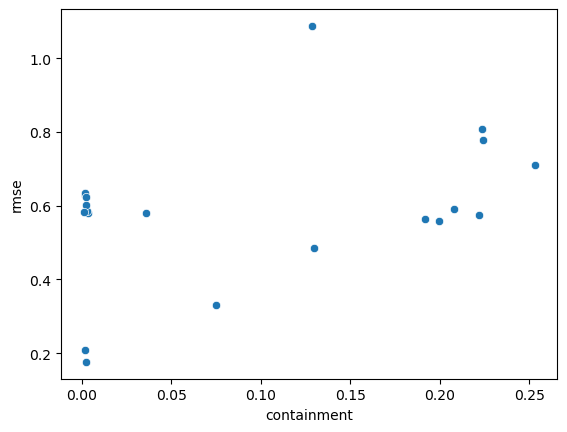

In [18]:
sns.scatterplot(data=cont_rmse, x="containment", y="rmse")

# Pre-join post-join sizes

In [38]:
df = pl.read_csv("results/results_1000iter.log")


In [39]:
df.filter(
    (pl.col("index_name") != "base_table") & (pl.col("aggregation") == "none")
).select(
    pl.col("source_table"),
    pl.col("size_prejoin"),
    pl.col("size_postjoin"),
    pl.col("target_dl")
).groupby(
    pl.col("target_dl"),
    pl.col("source_table")
).agg(
    pl.avg("size_prejoin").alias("avg_prejoin"),
    pl.avg("size_postjoin").alias("avg_postjoin"),
    pl.max("size_postjoin").alias("max_postjoin"),
).with_columns(
    (pl.col("avg_postjoin")/pl.col("avg_prejoin")).alias("scale_factor_avg")
)

target_dl,source_table,avg_prejoin,avg_postjoin,max_postjoin,scale_factor_avg
str,str,f64,f64,i64,f64
"""binary""","""presidential-r…",22084.0,136464.0,406155,6.179315
"""wordnet""","""company-employ…",3107.0,6096.0,11030,1.962021
"""wordnet""","""movies-prepare…",3853.0,4212.5,5095,1.093304
"""binary""","""movies-prepare…",3853.0,8688.75,19688,2.255061
"""binary""","""company-employ…",3107.0,26565.5,72163,8.550209
"""wordnet""","""presidential-r…",22084.0,30295.75,51969,1.371842


In [45]:
df.filter(
    (pl.col("index_name") != "base_table") & (pl.col("aggregation") == "none")
).select(
    pl.col("source_table"),
    pl.col("size_prejoin"),
    pl.col("size_postjoin"),
    pl.col("target_dl")
).with_columns(
    (pl.col("size_postjoin")/pl.col("size_prejoin")).alias("scale_factor")
).groupby(
    pl.col("target_dl"),
    pl.col("source_table")
).agg(
    pl.avg("size_prejoin").alias("avg_prejoin"),
    pl.avg("size_postjoin").alias("avg_postjoin"),
    pl.max("size_postjoin").alias("max_postjoin"),  
    pl.avg("scale_factor").alias("avg_scalefactor"),
    pl.max("scale_factor").alias("max_scalefactor"),  
).sort(
    pl.col("source_table"),
    pl.col("target_dl"),
)

target_dl,source_table,avg_prejoin,avg_postjoin,max_postjoin,avg_scalefactor,max_scalefactor
str,str,f64,f64,i64,f64,f64
"""binary""","""company-employ…",3107.0,26565.5,72163,8.550209,23.225941
"""wordnet""","""company-employ…",3107.0,6096.0,11030,1.962021,3.550048
"""binary""","""movies-prepare…",3853.0,8688.75,19688,2.255061,5.109785
"""wordnet""","""movies-prepare…",3853.0,4212.5,5095,1.093304,1.322346
"""binary""","""presidential-r…",22084.0,136464.0,406155,6.179315,18.391369
"""wordnet""","""presidential-r…",22084.0,30295.75,51969,1.371842,2.353242


# Scenario timers

In [254]:
df_scn = pl.read_csv("results/scenario_logger.log", has_header=False)
df_scn.columns = "scenario_id,git_hash,source_table,iterations,join_strategy,aggregation,target_dl,k_fold,n_candidates,start_process,end_process,start_load_index,end_load_index,start_querying,end_querying,start_evaluation,end_evaluation".split(",")


In [255]:
timer_columns = [col for col in df_scn.columns if (col.startswith("start_") or col.startswith("end_"))]

In [256]:
df_scn = df_scn.with_columns(
    pl.col(timer_columns).str.to_datetime()
)

In [257]:
timer_columns

['start_process',
 'end_process',
 'start_load_index',
 'end_load_index',
 'start_querying',
 'end_querying',
 'start_evaluation',
 'end_evaluation']

In [258]:
df_scn = df_scn.with_columns(
    (pl.col("end_process") - pl.col("start_process")).alias("duration_process"),
    (pl.col("end_load_index") - pl.col("start_load_index")).alias("duration_load_index"),
    (pl.col("end_querying") - pl.col("start_querying")).alias("duration_querying"),
    (pl.col("end_evaluation") - pl.col("start_evaluation")).alias("duration_evaluation"),
)


In [259]:

r_scn1=df_scn.filter(
    pl.col("iterations") == 500
).sort(["target_dl","source_table"]).filter(
    ~pl.col("source_table").is_in(["us-accidents-prepared", "presidential-results-prepared"])
).select(
    pl.col("scenario_id"),
    pl.col("source_table"),
    pl.col("join_strategy"),
    pl.col("aggregation"),
    pl.col("iterations"),
    pl.col("n_candidates"),
    pl.col([col for col in df_scn.columns if col.startswith("duration")])
)


In [260]:
r_scn1

scenario_id,source_table,join_strategy,aggregation,iterations,n_candidates,duration_process,duration_load_index,duration_querying,duration_evaluation
i64,str,str,str,i64,i64,duration[μs],duration[μs],duration[μs],duration[μs]
180,"""company-employ…","""left""","""none""",500,6,11m 42s 146908µs,271488µs,128210µs,11m 41s 723023µs
182,"""company-employ…","""left""","""dedup""",500,6,7m 9s 52256µs,238435µs,71863µs,7m 8s 732214µs
183,"""company-employ…","""left""","""dfs""",500,6,5m 35s 104059µs,256503µs,68622µs,5m 34s 770953µs
184,"""movies-prepare…","""left""","""none""",500,8,8m 33s 636300µs,200648µs,126259µs,8m 33s 301165µs
185,"""movies-prepare…","""left""","""dedup""",500,8,11m 41s 666856µs,256760µs,72613µs,11m 41s 330215µs
186,"""movies-prepare…","""left""","""dfs""",500,8,10m 7s 234226µs,187238µs,76148µs,10m 6s 961668µs
195,"""presidential-r…","""left""","""dedup""",500,4,10m 18s 129056µs,219889µs,90336µs,10m 17s 811373µs
197,"""presidential-r…","""left""","""dfs""",500,4,6m 25s 752577µs,321985µs,122619µs,6m 25s 299648µs
207,"""presidential-r…","""left""","""none""",500,4,4m 8s 843434µs,209452µs,88168µs,4m 8s 538216µs


In [261]:
r_scn1.pivot(
    values="process_in_seconds",
    columns="source_table",
    index=["target_dl", "aggregation"],
    aggregate_function="mean"
)

ColumnNotFoundError: target_dl

In [262]:
joined = df_p.join(
    df_scn,
    on="scenario_id"
)

In [263]:
rr = joined.groupby(
    ["variant", "index", "base_table", "aggregation"]
).agg(
    pl.col("avg_train").mean(),
    pl.col("n_candidates").mean()
).sort(["variant", "base_table"]).with_columns(
    pl.col("avg_train")*pl.col("n_candidates")*25
).filter(~pl.col("base_table").is_in(["us-accidents-prepared","presidential-results-prepared"]))

In [264]:
rr

variant,index,base_table,aggregation,avg_train,n_candidates
str,str,str,str,f64,f64
"""binary""","""minhash""","""company-employ…","""dedup""",1358.15931,6.0
"""binary""","""minhash""","""company-employ…","""none""",2972.997612,6.0
"""binary""","""base_table""","""company-employ…","""base_table""",1612.005162,6.0
"""binary""","""minhash""","""company-employ…","""dfs""",1343.992525,6.0
"""binary""","""minhash""","""movies-prepare…","""dedup""",2343.1143,8.0
"""binary""","""minhash""","""movies-prepare…","""none""",2256.738405,8.0
"""binary""","""base_table""","""movies-prepare…","""base_table""",2309.719947,8.0
"""binary""","""minhash""","""movies-prepare…","""dfs""",2299.995325,8.0
"""binary""","""base_table""","""presidential-r…","""base_table""",853.58158,4.0


In [265]:
rr.pivot(
    values="avg_train",
    columns="base_table",
    index=["variant", "index", "aggregation"],
    aggregate_function="mean"
)

variant,index,aggregation,company-employees-prepared,movies-prepared,presidential-results-prepared-new,us-accidents-prepared-new
str,str,str,f64,f64,f64,f64
"""binary""","""minhash""","""dedup""",1358.15931,2343.1143,1017.467255,null
"""binary""","""minhash""","""none""",2972.997612,2256.738405,null,null
"""binary""","""base_table""","""base_table""",1612.005162,2309.719947,853.58158,null
"""binary""","""minhash""","""dfs""",1343.992525,2299.995325,1251.29129,null
"""wordnet_big""","""minhash""","""none""",9429.09824,null,17868.4151,14795.295875
"""wordnet_big""","""base_table""","""base_table""",8073.677167,5030.245647,9296.990192,13403.203625
"""wordnet_big""","""minhash""","""dfs""",9831.609775,5610.97507,19647.7359,14974.485195
"""wordnet_big""","""minhash""","""dedup""",9521.23607,5275.9193,17859.05155,null


In [266]:
r_scn = df_scn.filter(
    (pl.col("iterations") == 500 ) &
    (~pl.col("source_table").is_in(["us-accidents-prepared","presidential-results-prepared"]))
).with_columns(
    (pl.col("duration_process").dt.hours()*3600+
    pl.col("duration_process").dt.minutes()*60+
    pl.col("duration_process").dt.seconds()+
    pl.col("duration_process").dt.microseconds()*1e-6).alias("process_in_seconds")
    )
# .select(
#         pl.col("scenario_id"),
#         pl.col("source_table"),
#         pl.col("aggregation"),
#         pl.col("target_dl"),
#         pl.col("process_in_seconds")
#     )

In [267]:
r_scn.select(
    pl.col("scenario_id"),
    pl.col("target_dl"),
    pl.col("source_table"),
    pl.col("join_strategy"),
    pl.col("aggregation"),
    pl.col("iterations"),
    pl.col("n_candidates"),
    pl.col([col for col in df_scn.columns if col.startswith("duration")])
)


scenario_id,target_dl,source_table,join_strategy,aggregation,iterations,n_candidates,duration_process,duration_load_index,duration_querying,duration_evaluation
i64,str,str,str,str,i64,i64,duration[μs],duration[μs],duration[μs],duration[μs]
171,"""wordnet_big""","""company-employ…","""left""","""none""",500,50,32m 14s 796021µs,9s 579817µs,91089µs,32m 5s 103490µs
172,"""wordnet_big""","""company-employ…","""left""","""dedup""",500,50,41m 34s 582947µs,9s 575038µs,87532µs,41m 24s 897368µs
173,"""wordnet_big""","""company-employ…","""left""","""dfs""",500,50,35m 11s 72214µs,9s 403545µs,89306µs,35m 1s 556522µs
175,"""wordnet_big""","""movies-prepare…","""left""","""dedup""",500,23,25m 23s 627060µs,9s 579281µs,71742µs,25m 13s 956394µs
176,"""wordnet_big""","""movies-prepare…","""left""","""dfs""",500,23,23m 35s 721900µs,9s 684723µs,82287µs,23m 25s 932413µs
180,"""binary""","""company-employ…","""left""","""none""",500,6,11m 42s 146908µs,271488µs,128210µs,11m 41s 723023µs
182,"""binary""","""company-employ…","""left""","""dedup""",500,6,7m 9s 52256µs,238435µs,71863µs,7m 8s 732214µs
183,"""binary""","""company-employ…","""left""","""dfs""",500,6,5m 35s 104059µs,256503µs,68622µs,5m 34s 770953µs
184,"""binary""","""movies-prepare…","""left""","""none""",500,8,8m 33s 636300µs,200648µs,126259µs,8m 33s 301165µs


In [268]:
r_scn.pivot(
    values="duration_process",
    columns="source_table",
    index=["target_dl", "aggregation"],
    aggregate_function="mean"
)

target_dl,aggregation,company-employees-prepared,movies-prepared,us-accidents-prepared-new,presidential-results-prepared-new
str,str,duration[μs],duration[μs],duration[μs],duration[μs]
"""wordnet_big""","""none""",32m 14s 796021µs,19m 2s 951924µs,50m 40s 80338µs,1h 37s 448697µs
"""wordnet_big""","""dedup""",41m 34s 582947µs,25m 23s 627060µs,1h 1m 42s 321960µs,2h 12m 10s 169247µs
"""wordnet_big""","""dfs""",35m 11s 72214µs,23m 35s 721900µs,55m 1s 473562µs,1h 10m 25s 269734µs
"""binary""","""none""",11m 42s 146908µs,8m 33s 636300µs,9m 35s 454103µs,4m 8s 843434µs
"""binary""","""dedup""",7m 9s 52256µs,11m 41s 666856µs,14m 18s 317303µs,10m 18s 129056µs
"""binary""","""dfs""",5m 35s 104059µs,10m 7s 234226µs,12m 24s 52041µs,6m 25s 752577µs


In [269]:
rr

variant,index,base_table,aggregation,avg_train,n_candidates
str,str,str,str,f64,f64
"""binary""","""minhash""","""company-employ…","""dedup""",1358.15931,6.0
"""binary""","""minhash""","""company-employ…","""none""",2972.997612,6.0
"""binary""","""base_table""","""company-employ…","""base_table""",1612.005162,6.0
"""binary""","""minhash""","""company-employ…","""dfs""",1343.992525,6.0
"""binary""","""minhash""","""movies-prepare…","""dedup""",2343.1143,8.0
"""binary""","""minhash""","""movies-prepare…","""none""",2256.738405,8.0
"""binary""","""base_table""","""movies-prepare…","""base_table""",2309.719947,8.0
"""binary""","""minhash""","""movies-prepare…","""dfs""",2299.995325,8.0
"""binary""","""base_table""","""presidential-r…","""base_table""",853.58158,4.0


In [189]:
joined.groupby(
    ["variant", "index", "base_table", "aggregation"]
).agg(
    pl.col("avg_train").mean(),
    pl.col("n_candidates").mean()
).sort(["variant", "base_table"]).filter(
    (pl.col("index") =="base_table") & 
    (~pl.col("base_table").is_in(["us-accidents-prepared","presidential-results-prepared"]))
    ).with_columns(
        pl.col("avg_train") * 25
    )

variant,index,base_table,aggregation,avg_train,n_candidates
str,str,str,str,f64,f64
"""binary""","""base_table""","""company-employ…","""base_table""",268.667527,6.0
"""binary""","""base_table""","""movies-prepare…","""base_table""",288.714993,8.0
"""binary""","""base_table""","""presidential-r…","""base_table""",213.395395,4.0
"""wordnet_big""","""base_table""","""company-employ…","""base_table""",161.473543,50.0
"""wordnet_big""","""base_table""","""movies-prepare…","""base_table""",218.706333,23.0
"""wordnet_big""","""base_table""","""presidential-r…","""base_table""",182.442082,50.0
"""wordnet_big""","""base_table""","""us-accidents-p…","""base_table""",268.064073,50.0
